## Imports

In [1]:
%matplotlib inline

import os
import sys
import re
import nltk
import json
import gensim
import dateutil
import datetime
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import sparse
from urllib import request
from sklearn.svm import SVC
from functools import reduce
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from IPython.display import Image
from typing import List, Callable, Dict
from sklearn.metrics import r2_score
sns.set(style="ticks", color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from utils import hyperparameterTuning_RandomForest
from utils import hyperparameterTuning_XGBoost
from utils import hyperparameterTuning_MLP
from utils import plot_feature_importance
from utils import featureScore
from utils import folderPath
from utils import metrics
from utils import removeColumnContainString
from utils import Feature_Extraction
from utils import Normalizing

import os, shutil 

random_state=2022

In [2]:
!pip install fsspec

Read the dataset

In [3]:
figurePath=folderPath('SavedFigures')
datasetePath=folderPath('Dataset')  

1
1


In [4]:
dataset1='/content/drive/MyDrive/NLP/final_dataset.csv'
dataset2='/content/drive/MyDrive/NLP/Industry.csv'

In [5]:
df=pd.read_csv(dataset1)
industry=pd.read_csv(dataset2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.shape

(74549, 20)

In [7]:
industry.shape

(834, 4)

In [8]:
dropped = ['profile_name', 'profile_image_link', 'biography','id','thumbnails', 'url', 'location','image_url','external_url','media_type','business_email','is_verified']
data = df.drop(dropped,axis=1)
data = data[data['account'].notna()]
data

,account,caption,following,likes,posts_count,followers,datetime,comments
10,chelsea_bridge_clinic,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1612780000000.0,0.0
11,chelsea_bridge_clinic,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1611240000000.0,0.0
12,numberoneedin,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,1645290000000.0,2.0
13,numberoneedin,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1643660000000.0,1.0
14,numberoneedin,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1643220000000.0,1.0
...,...,...,...,...,...,...,...,...
74544,thesavoylondon,"Alongside hospitality, the performing arts hav...",599.0,4079,1933.0,167394.0,1610730000000.0,67
74545,thesavoylondon,This! Isn’t this what we are looking forward ...,599.0,1621,1933.0,167394.0,1610550000000.0,34
74546,thesavoylondon,"For those of you who are missing London town, ...",599.0,1548,1933.0,167394.0,1610370000000.0,28
74547,thesavoylondon,While we’re closed we’re going to try and keep...,599.0,2637,1933.0,167394.0,1609940000000.0,68


In [9]:
rm_list = []  

for i in range(data.shape[0]):
    if type(data["datetime"].values[i]) != float:
        rm_list.append(i)

len(rm_list)
for i in rm_list:
    data.drop([i], axis=0, inplace=True)

In [10]:
data

,account,caption,following,likes,posts_count,followers,datetime,comments
10,chelsea_bridge_clinic,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1612780000000.0,0.0
11,chelsea_bridge_clinic,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1611240000000.0,0.0
12,numberoneedin,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,1645290000000.0,2.0
13,numberoneedin,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1643660000000.0,1.0
14,numberoneedin,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1643220000000.0,1.0
...,...,...,...,...,...,...,...,...
74544,thesavoylondon,"Alongside hospitality, the performing arts hav...",599.0,4079,1933.0,167394.0,1610730000000.0,67
74545,thesavoylondon,This! Isn’t this what we are looking forward ...,599.0,1621,1933.0,167394.0,1610550000000.0,34
74546,thesavoylondon,"For those of you who are missing London town, ...",599.0,1548,1933.0,167394.0,1610370000000.0,28
74547,thesavoylondon,While we’re closed we’re going to try and keep...,599.0,2637,1933.0,167394.0,1609940000000.0,68


In [11]:
len(data.account.unique())

648

In [12]:
# data.drop(['Unnamed: 0'], axis = 1,inplace=True)
df_industry=industry.rename(columns={'ACCOUNT':'account'})
df_industry.head()

data=pd.merge(data, df_industry, on=['account'], how='left')

In [13]:
data.to_csv('/content/drive/MyDrive/NLP/1.csv')

In [14]:
data=pd.read_csv("/content/drive/MyDrive/NLP/1.csv")

In [15]:
data.shape

(41741, 12)

In [16]:
data['INDUSTRY'].value_counts()

hospitality           26800
cosmetics             13684
fitness                 588
retail                  218
sport & recreation      191
real estate             158
childcare                54
fashion                  48
Name: INDUSTRY, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

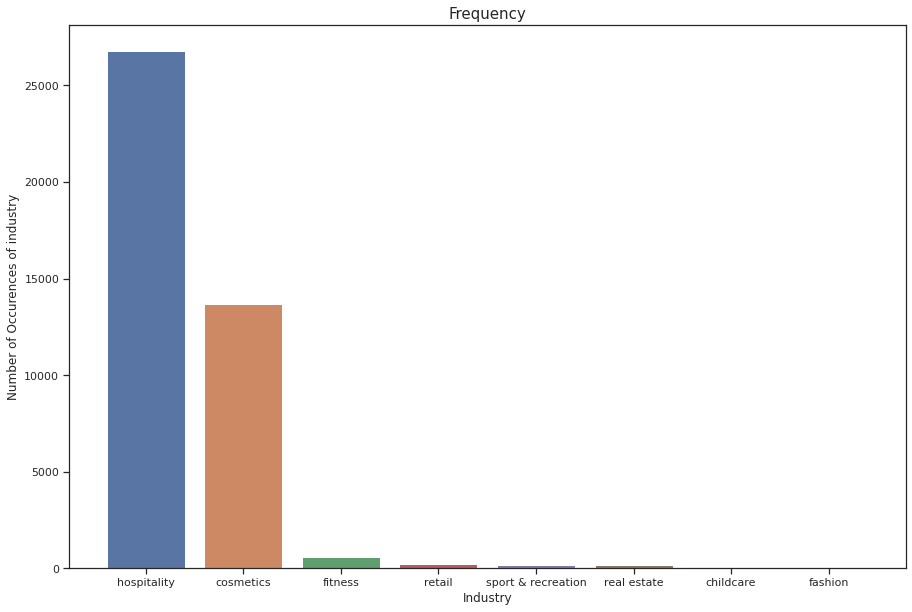

In [17]:
countIndustry=data['INDUSTRY'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countIndustry.index,countIndustry.values)
plt.ylabel('Number of Occurences of industry',fontsize=12)
plt.xlabel('Industry',fontsize=12)
plt.title('Frequency',fontsize=15)
plt.plot()

In [18]:
data['SUB-CATEGORY'].value_counts()

beauty clinic                    13551
restaurant                        9676
hotel                             6494
bakery                            5591
café                              2445
gym                                271
brewery                            257
cocktail bar                       236
boutique wellness studio           200
bar                                186
bar & grill                        182
breakfast & brunch restaurant      164
coffee / food shop                 159
estate agents                      158
ice cream shop                     145
pub                                139
serviced apartments                138
wine bar & shop                    133
chocolate shop                     125
streetfood market                  125
dessert shop                       122
bootcamp classes                   117
fast food chain                    109
beauty products                    103
beer garden                         99
bar & kitchen            

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

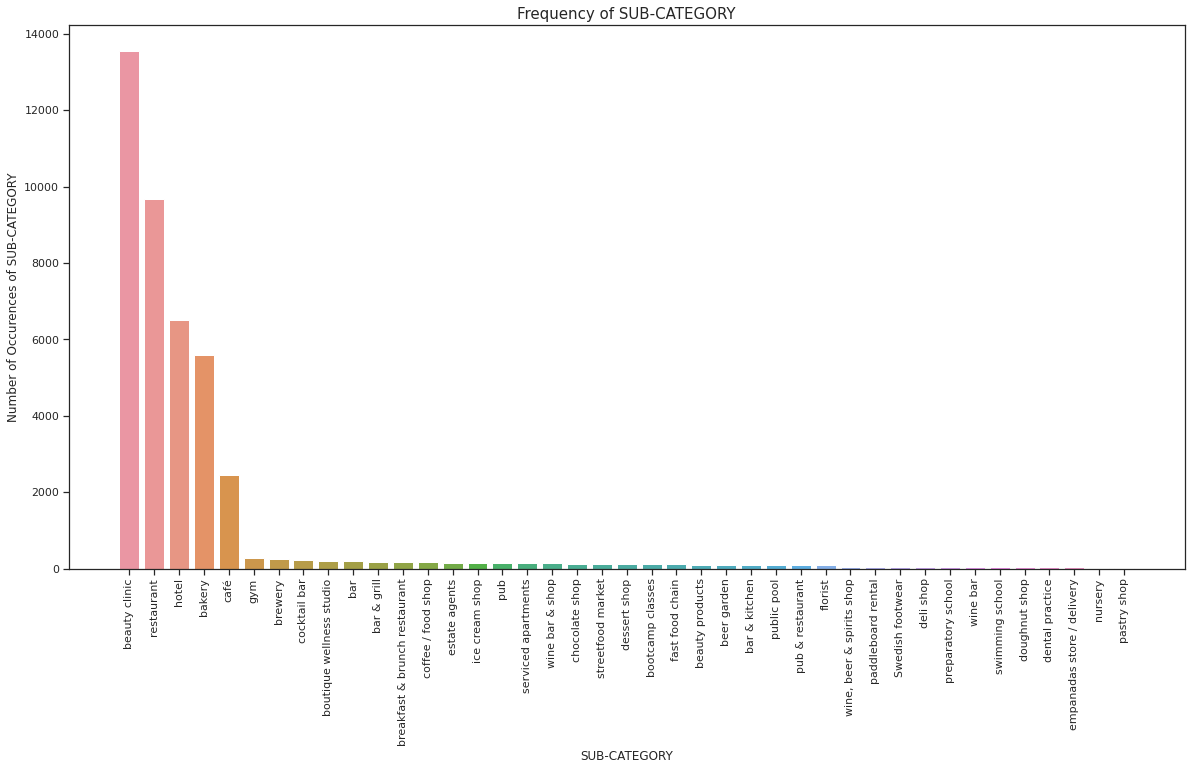

In [19]:
countSubIndustry=data['SUB-CATEGORY'].value_counts()
plt.figure(figsize=(20,10))
sns.barplot(countSubIndustry.index,countSubIndustry.values)
plt.ylabel('Number of Occurences of SUB-CATEGORY',fontsize=12)
plt.xlabel('SUB-CATEGORY',fontsize=12)
plt.xticks(rotation=90)
plt.title('Frequency of SUB-CATEGORY',fontsize=15)
# plt.xticks(ticks=countDow.index,rotation='vertical')
plt.plot()

In [20]:
data = pd.get_dummies(data, columns=['INDUSTRY'])

In [21]:
data.drop(['account'], axis = 1,inplace=True)
data.drop(['SUB-CATEGORY'], axis = 1,inplace=True)

In [22]:
data

,Unnamed: 0,caption,following,likes,posts_count,followers,datetime,comments,REGION,INDUSTRY_childcare,INDUSTRY_cosmetics,INDUSTRY_fashion,INDUSTRY_fitness,INDUSTRY_hospitality,INDUSTRY_real estate,INDUSTRY_retail,INDUSTRY_sport & recreation
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1.612780e+12,0.0,UK,0,1,0,0,0,0,0,0
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1.611240e+12,0.0,UK,0,1,0,0,0,0,0,0
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,1.645290e+12,2.0,UK,0,0,0,0,1,0,0,0
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1.643660e+12,1.0,UK,0,0,0,0,1,0,0,0
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1.643220e+12,1.0,UK,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,1.610730e+12,67.0,UK,0,0,0,0,1,0,0,0
41737,41737,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,1.610550e+12,34.0,UK,0,0,0,0,1,0,0,0
41738,41738,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,1.610370e+12,28.0,UK,0,0,0,0,1,0,0,0
41739,41739,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,1.609940e+12,68.0,UK,0,0,0,0,1,0,0,0


In [23]:
#Converting the columns into the float datatype
a=['following','likes','posts_count','followers','comments']
for i in a:
  data[i]= data[i].astype(str).astype(float)
data

,Unnamed: 0,caption,following,likes,posts_count,followers,datetime,comments,REGION,INDUSTRY_childcare,INDUSTRY_cosmetics,INDUSTRY_fashion,INDUSTRY_fitness,INDUSTRY_hospitality,INDUSTRY_real estate,INDUSTRY_retail,INDUSTRY_sport & recreation
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1.612780e+12,0.0,UK,0,1,0,0,0,0,0,0
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1.611240e+12,0.0,UK,0,1,0,0,0,0,0,0
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,1.645290e+12,2.0,UK,0,0,0,0,1,0,0,0
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,1.643660e+12,1.0,UK,0,0,0,0,1,0,0,0
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,1.643220e+12,1.0,UK,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,1.610730e+12,67.0,UK,0,0,0,0,1,0,0,0
41737,41737,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,1.610550e+12,34.0,UK,0,0,0,0,1,0,0,0
41738,41738,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,1.610370e+12,28.0,UK,0,0,0,0,1,0,0,0
41739,41739,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,1.609940e+12,68.0,UK,0,0,0,0,1,0,0,0


In [24]:
data = data[data['datetime'].notna()]

In [25]:
import datetime

def timeStampConversion(x):
    return datetime.datetime.fromtimestamp(int(x)/1000)

data['datetime'] = pd.to_numeric(data['datetime'], downcast="float")
data['datetime'] = data['datetime'].apply(lambda x: timeStampConversion(x)) 
data["datetime"] = pd.to_datetime(data["datetime"])

In [26]:
data['Dow'] = data['datetime'].dt.weekday
data['Hod']= data['datetime'].dt.hour
data['Date']= data['datetime'].dt.date

In [27]:
data

,Unnamed: 0,caption,following,likes,posts_count,followers,datetime,comments,REGION,INDUSTRY_childcare,INDUSTRY_cosmetics,INDUSTRY_fashion,INDUSTRY_fitness,INDUSTRY_hospitality,INDUSTRY_real estate,INDUSTRY_retail,INDUSTRY_sport & recreation,Dow,Hod,Date
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,2021-02-08 10:26:51.520,0.0,UK,0,1,0,0,0,0,0,0,0,10,2021-02-08
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,2021-01-21 14:40:46.592,0.0,UK,0,1,0,0,0,0,0,0,3,14,2021-01-21
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,2022-02-19 17:01:01.824,2.0,UK,0,0,0,0,1,0,0,0,5,17,2022-02-19
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,2022-01-31 20:14:10.432,1.0,UK,0,0,0,0,1,0,0,0,0,20,2022-01-31
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,2022-01-26 18:00:41.728,1.0,UK,0,0,0,0,1,0,0,0,2,18,2022-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,2021-01-15 17:00:45.440,67.0,UK,0,0,0,0,1,0,0,0,4,17,2021-01-15
41737,41737,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,2021-01-13 14:59:12.512,34.0,UK,0,0,0,0,1,0,0,0,2,14,2021-01-13
41738,41738,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,2021-01-11 12:59:50.656,28.0,UK,0,0,0,0,1,0,0,0,0,12,2021-01-11
41739,41739,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,2021-01-06 13:32:23.424,68.0,UK,0,0,0,0,1,0,0,0,2,13,2021-01-06


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

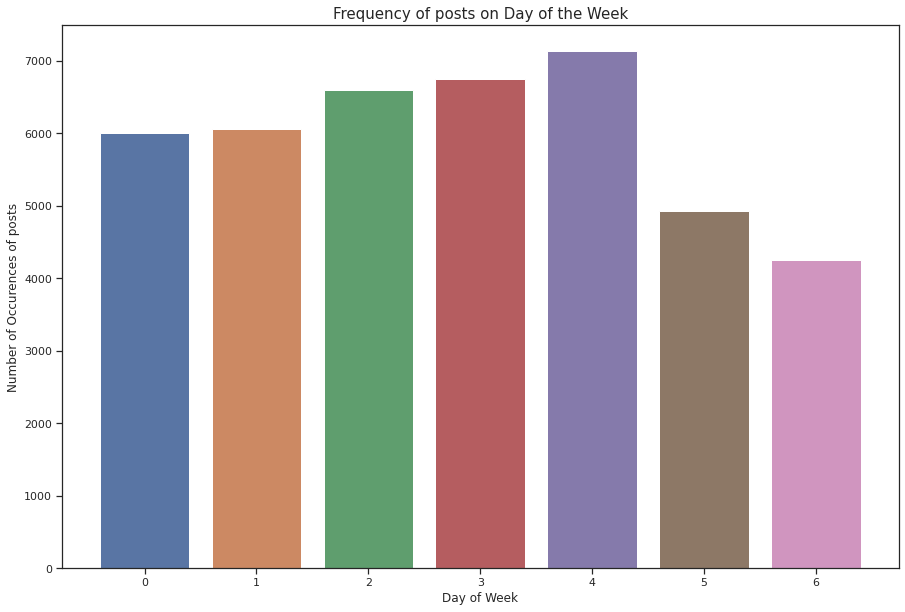

In [28]:
countDow=data['Dow'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countDow.index,countDow.values)
plt.ylabel('Number of Occurences of posts',fontsize=12)
plt.xlabel('Day of Week',fontsize=12)
plt.title('Frequency of posts on Day of the Week',fontsize=15)
# plt.xticks(ticks=countDow.index,rotation='vertical')
plt.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


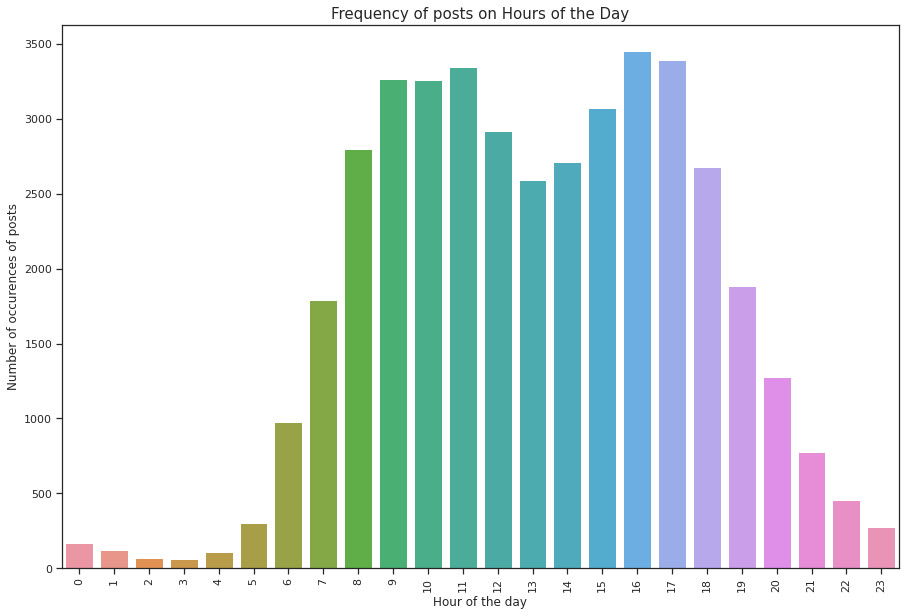

In [29]:
countHour=data['Hod'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countHour.index,countHour.values)
plt.ylabel('Number of occurences of posts',fontsize=12)
plt.xlabel('Hour of the day',fontsize=12)
plt.title('Frequency of posts on Hours of the Day',fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

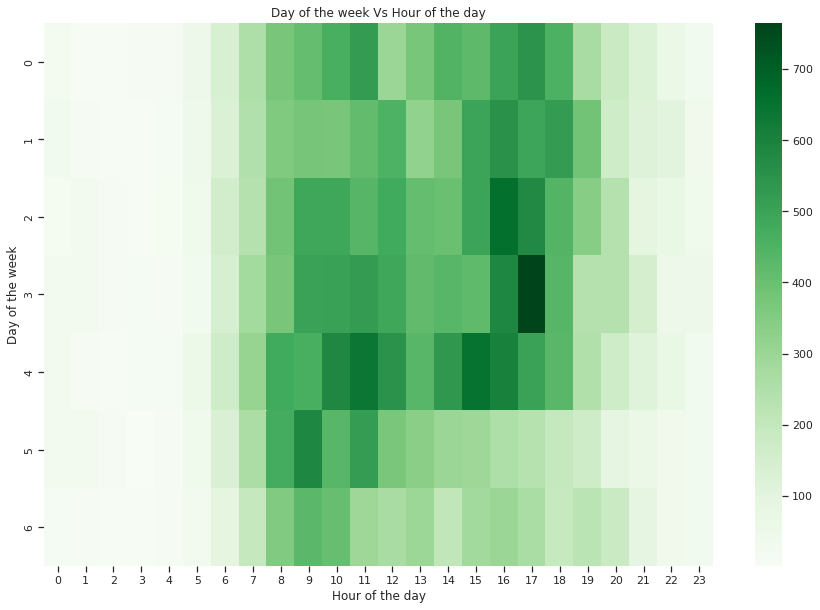

In [30]:
grp = data.groupby(['Dow','Hod'])['followers'].aggregate('count').reset_index()
grp = grp.pivot(index='Dow',columns='Hod',values='followers')
plt.figure(figsize=(15,10))
sns.heatmap(grp,cmap='Greens')
plt.title("Day of the week Vs Hour of the day")
plt.xlabel('Hour of the day')
plt.ylabel('Day of the week')
plt.show()

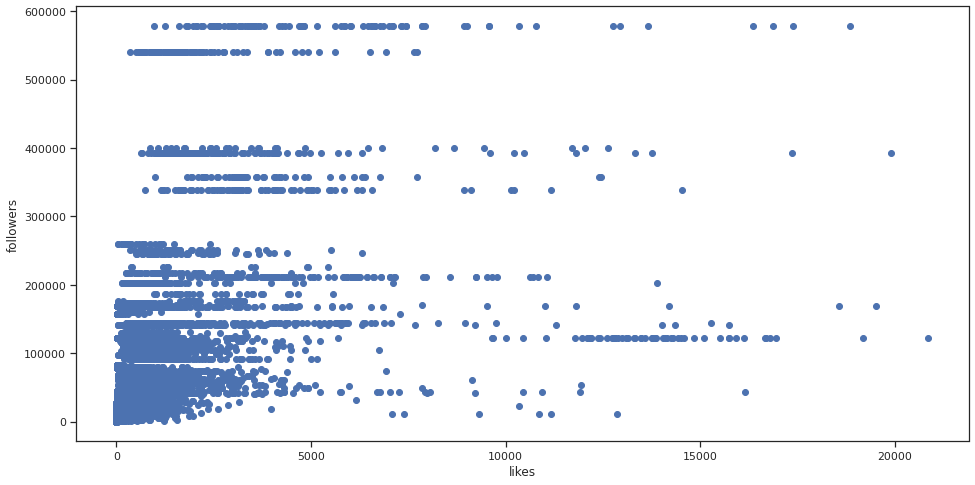

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['likes'], data['followers'])
ax.set_xlabel('likes')
ax.set_ylabel('followers')
plt.show()

In [32]:
data['mon']=(data['Dow']==0).astype(int)
data['tue']=(data['Dow']==1).astype(int)
data['wed']=(data['Dow']==2).astype(int)
data['thu']=(data['Dow']==3).astype(int)
data['fri']=(data['Dow']==4).astype(int)  
data['sat']=(data['Dow']==5).astype(int)
data['sun']=(data['Dow']==6).astype(int)

In [33]:
data = data.drop(['Dow'], axis=1)
data.drop(['datetime'], axis=1, inplace=True)

In [34]:
data.drop(['comments'], axis=1, inplace=True)
data.drop(['Date'], axis=1, inplace=True)
data=data.astype(str)

In [35]:
data.head()

,Unnamed: 0,caption,following,likes,posts_count,followers,REGION,INDUSTRY_childcare,INDUSTRY_cosmetics,INDUSTRY_fashion,...,INDUSTRY_retail,INDUSTRY_sport & recreation,Hod,mon,tue,wed,thu,fri,sat,sun
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,UK,0,1,0,...,0,0,10,1,0,0,0,0,0,0
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,UK,0,1,0,...,0,0,14,0,0,0,1,0,0,0
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,UK,0,0,0,...,0,0,17,0,0,0,0,0,1,0
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,UK,0,0,0,...,0,0,20,1,0,0,0,0,0,0
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,UK,0,0,0,...,0,0,18,0,0,1,0,0,0,0


In [36]:
def label(column):    
    le = preprocessing.LabelEncoder()
    le.fit(data[column])
    list(le.classes_)
    num=le.transform(data[column])
    data[column]=num

In [37]:
data

,Unnamed: 0,caption,following,likes,posts_count,followers,REGION,INDUSTRY_childcare,INDUSTRY_cosmetics,INDUSTRY_fashion,...,INDUSTRY_retail,INDUSTRY_sport & recreation,Hod,mon,tue,wed,thu,fri,sat,sun
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,UK,0,1,0,...,0,0,10,1,0,0,0,0,0,0
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,UK,0,1,0,...,0,0,14,0,0,0,1,0,0,0
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,UK,0,0,0,...,0,0,17,0,0,0,0,0,1,0
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,UK,0,0,0,...,0,0,20,1,0,0,0,0,0,0
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,UK,0,0,0,...,0,0,18,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,UK,0,0,0,...,0,0,17,0,0,0,0,1,0,0
41737,41737,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,UK,0,0,0,...,0,0,14,0,0,1,0,0,0,0
41738,41738,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,UK,0,0,0,...,0,0,12,1,0,0,0,0,0,0
41739,41739,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,UK,0,0,0,...,0,0,13,0,0,1,0,0,0,0


In [38]:
data.columns

Index(['Unnamed: 0', 'caption', 'following', 'likes', 'posts_count',
       'followers', 'REGION', 'INDUSTRY_childcare', 'INDUSTRY_cosmetics',
       'INDUSTRY_fashion', 'INDUSTRY_fitness', 'INDUSTRY_hospitality',
       'INDUSTRY_real estate', 'INDUSTRY_retail',
       'INDUSTRY_sport & recreation', 'Hod', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun'],
      dtype='object')

In [39]:
dropped = ['INDUSTRY_fashion','INDUSTRY_retail','INDUSTRY_childcare','INDUSTRY_fitness','INDUSTRY_sport & recreation','INDUSTRY_childcare','INDUSTRY_real estate']
data.drop(dropped,axis=1,inplace=True)
data

,Unnamed: 0,caption,following,likes,posts_count,followers,REGION,INDUSTRY_cosmetics,INDUSTRY_hospitality,Hod,mon,tue,wed,thu,fri,sat,sun
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,UK,1,0,10,1,0,0,0,0,0,0
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,UK,1,0,14,0,0,0,1,0,0,0
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,UK,0,1,17,0,0,0,0,0,1,0
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,UK,0,1,20,1,0,0,0,0,0,0
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,UK,0,1,18,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,UK,0,1,17,0,0,0,0,1,0,0
41737,41737,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,UK,0,1,14,0,0,1,0,0,0,0
41738,41738,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,UK,0,1,12,1,0,0,0,0,0,0
41739,41739,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,UK,0,1,13,0,0,1,0,0,0,0


In [40]:
# label('INDUSTRY')
# label('REGION')
# data.drop(['INDUSTRY'], axis=1, inplace=True)

data.drop(['REGION'], axis=1, inplace=True)

In [41]:
data

,Unnamed: 0,caption,following,likes,posts_count,followers,INDUSTRY_cosmetics,INDUSTRY_hospitality,Hod,mon,tue,wed,thu,fri,sat,sun
0,0,𝗗𝗶𝗱 𝘆𝗼𝘂 𝗸𝗻𝗼𝘄 𝘁𝗵𝗮𝘁 𝘆𝗼𝘂 𝗰𝗮𝗻 𝘁𝗲𝘀𝘁 𝗳𝗼𝗿 𝗖𝗼𝘃𝗶𝗱 𝘄𝗶𝘁𝗵 ...,964.0,14.0,47.0,1093.0,1,0,10,1,0,0,0,0,0,0
1,1,𝗧𝗛𝗔𝗡𝗞 𝗬𝗢𝗨 👏\n.\nWe are very grateful for all t...,964.0,12.0,47.0,1093.0,1,0,14,0,0,0,1,0,0,0
2,2,"Hand dived Isle of Jura scallop, smoked roe, l...",308.0,100.0,343.0,4202.0,0,1,17,0,0,0,0,0,1,0
3,3,Jerusalem Artichoke prepared as your first des...,308.0,81.0,343.0,4202.0,0,1,20,1,0,0,0,0,0,0
4,4,Main course from our seasonal 7 course menu: B...,308.0,146.0,343.0,4202.0,0,1,18,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,"Alongside hospitality, the performing arts hav...",599.0,4079.0,1933.0,167394.0,0,1,17,0,0,0,0,1,0,0
41737,41737,This! Isn’t this what we are looking forward ...,599.0,1621.0,1933.0,167394.0,0,1,14,0,0,1,0,0,0,0
41738,41738,"For those of you who are missing London town, ...",599.0,1548.0,1933.0,167394.0,0,1,12,1,0,0,0,0,0,0
41739,41739,While we’re closed we’re going to try and keep...,599.0,2637.0,1933.0,167394.0,0,1,13,0,0,1,0,0,0,0


In [42]:
data.to_csv('/content/drive/MyDrive/NLP/2.csv')

In [43]:
data.drop(['caption'], axis=1, inplace=True)

In [44]:
data.head()

,Unnamed: 0,following,likes,posts_count,followers,INDUSTRY_cosmetics,INDUSTRY_hospitality,Hod,mon,tue,wed,thu,fri,sat,sun
0,0,964.0,14.0,47.0,1093.0,1,0,10,1,0,0,0,0,0,0
1,1,964.0,12.0,47.0,1093.0,1,0,14,0,0,0,1,0,0,0
2,2,308.0,100.0,343.0,4202.0,0,1,17,0,0,0,0,0,1,0
3,3,308.0,81.0,343.0,4202.0,0,1,20,1,0,0,0,0,0,0
4,4,308.0,146.0,343.0,4202.0,0,1,18,0,0,1,0,0,0,0


In [45]:
df = pd.DataFrame(data)
data=df.astype(str)
normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_df = pd.DataFrame(normalizer.fit_transform(data),  columns = data.columns)

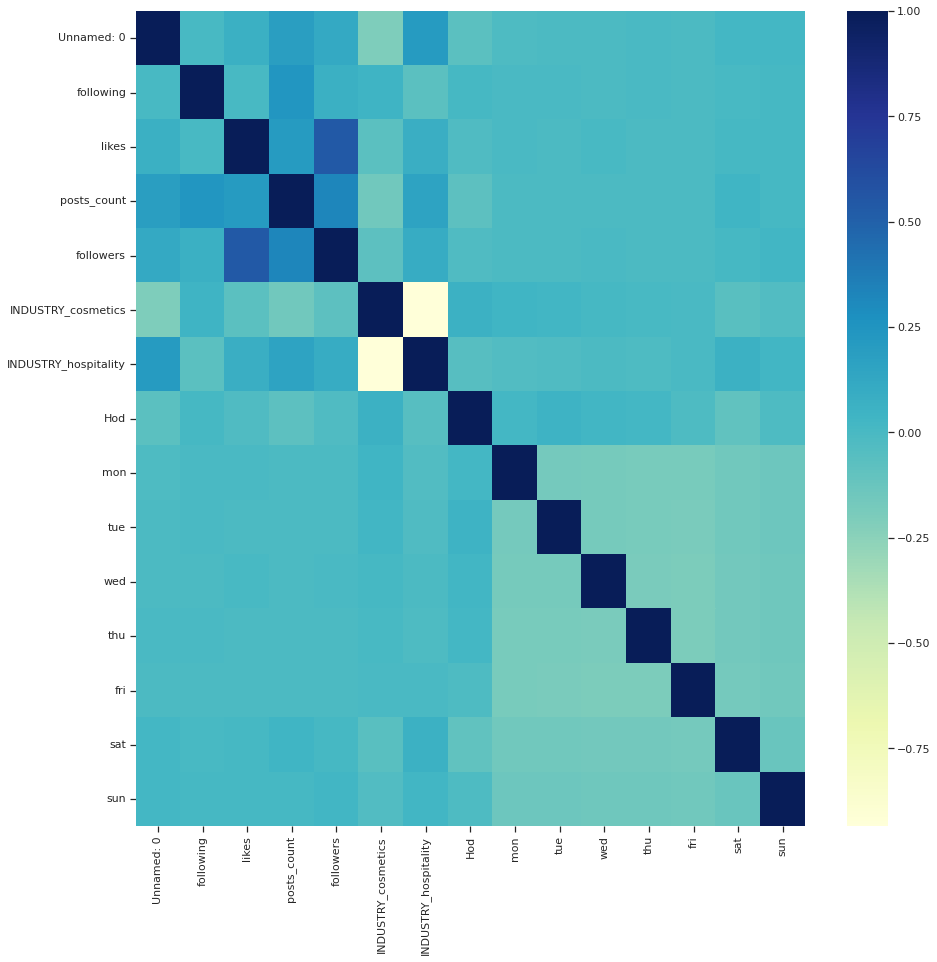

In [46]:
%matplotlib inline
plt.figure(figsize=(15,15))
sns.heatmap(normalized_df.corr(),cmap="YlGnBu")
plt.show()

In [47]:
y=normalized_df["likes"]
X = normalized_df.drop('likes', axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [49]:
#Converting the columns into the float datatype
a=['following','posts_count','Hod','mon','tue','wed','thu','fri','sat','sun']
for i in a:
  data[i]= data[i].astype(str).astype(float)
data

,Unnamed: 0,following,likes,posts_count,followers,INDUSTRY_cosmetics,INDUSTRY_hospitality,Hod,mon,tue,wed,thu,fri,sat,sun
0,0,964.0,14.0,47.0,1093.0,1,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,964.0,12.0,47.0,1093.0,1,0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,308.0,100.0,343.0,4202.0,0,1,17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,308.0,81.0,343.0,4202.0,0,1,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,308.0,146.0,343.0,4202.0,0,1,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41736,41736,599.0,4079.0,1933.0,167394.0,0,1,17.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41737,41737,599.0,1621.0,1933.0,167394.0,0,1,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41738,41738,599.0,1548.0,1933.0,167394.0,0,1,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
41739,41739,599.0,2637.0,1933.0,167394.0,0,1,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:
# hyperparameterTuning_XGBoost(X_train,y_train)

In [51]:
dict_info = {'Model': [], 'RMSE': [], 'R2': [],'MAE': [], 'RMSLE': [],'max_error_':[]}

## XGBoost 

In [52]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.03,max_depth = 5, min_child_weight=4,nthread = 4, n_estimators = 500,subsample=0.7,random_state=random_state)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

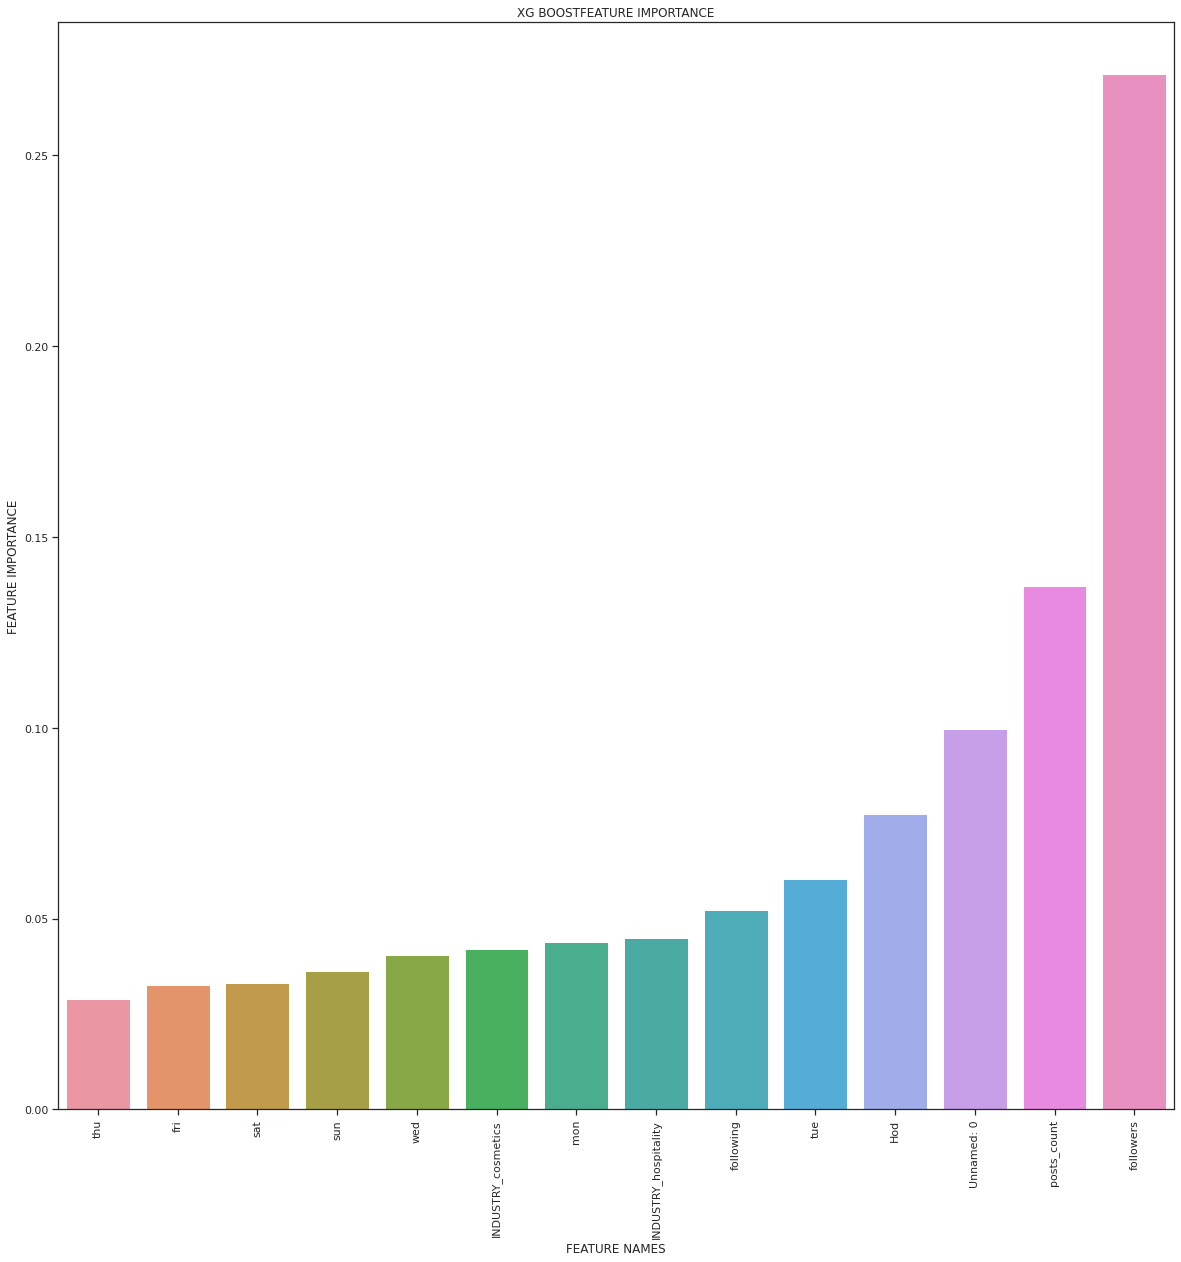

In [53]:

plot_feature_importance(xg_reg.feature_importances_,X_train.columns,'XG BOOST')

In [54]:
rmse,R2,MAE,MSE,RMSLE,max_error_= metrics(y_test,y_pred)

dict_info['Model'].append('XGboost')
dict_info['RMSE'].append(rmse)
dict_info['R2'].append(R2)
dict_info['MAE'].append(MAE)
dict_info['RMSLE'].append(RMSLE)
dict_info['max_error_'].append(max_error_)



RMSE: 0.029022

R2 Score: 0.509933

MAE : 0.008538

MSE : 0.000842

RMSLE : -3.539710

max_error : 0.700299



## Random Forest

In [55]:
# hyperparameterTuning_RandomForest(X_train,y_train)

In [56]:
rnd_clf = RandomForestRegressor(n_estimators=20, min_samples_split=6, min_samples_leaf=4,max_features='auto',max_depth=10,bootstrap=True,random_state=random_state)
rnd_clf.fit(X_train, y_train)
y_pred_rnd_clf = rnd_clf.predict(X_test)

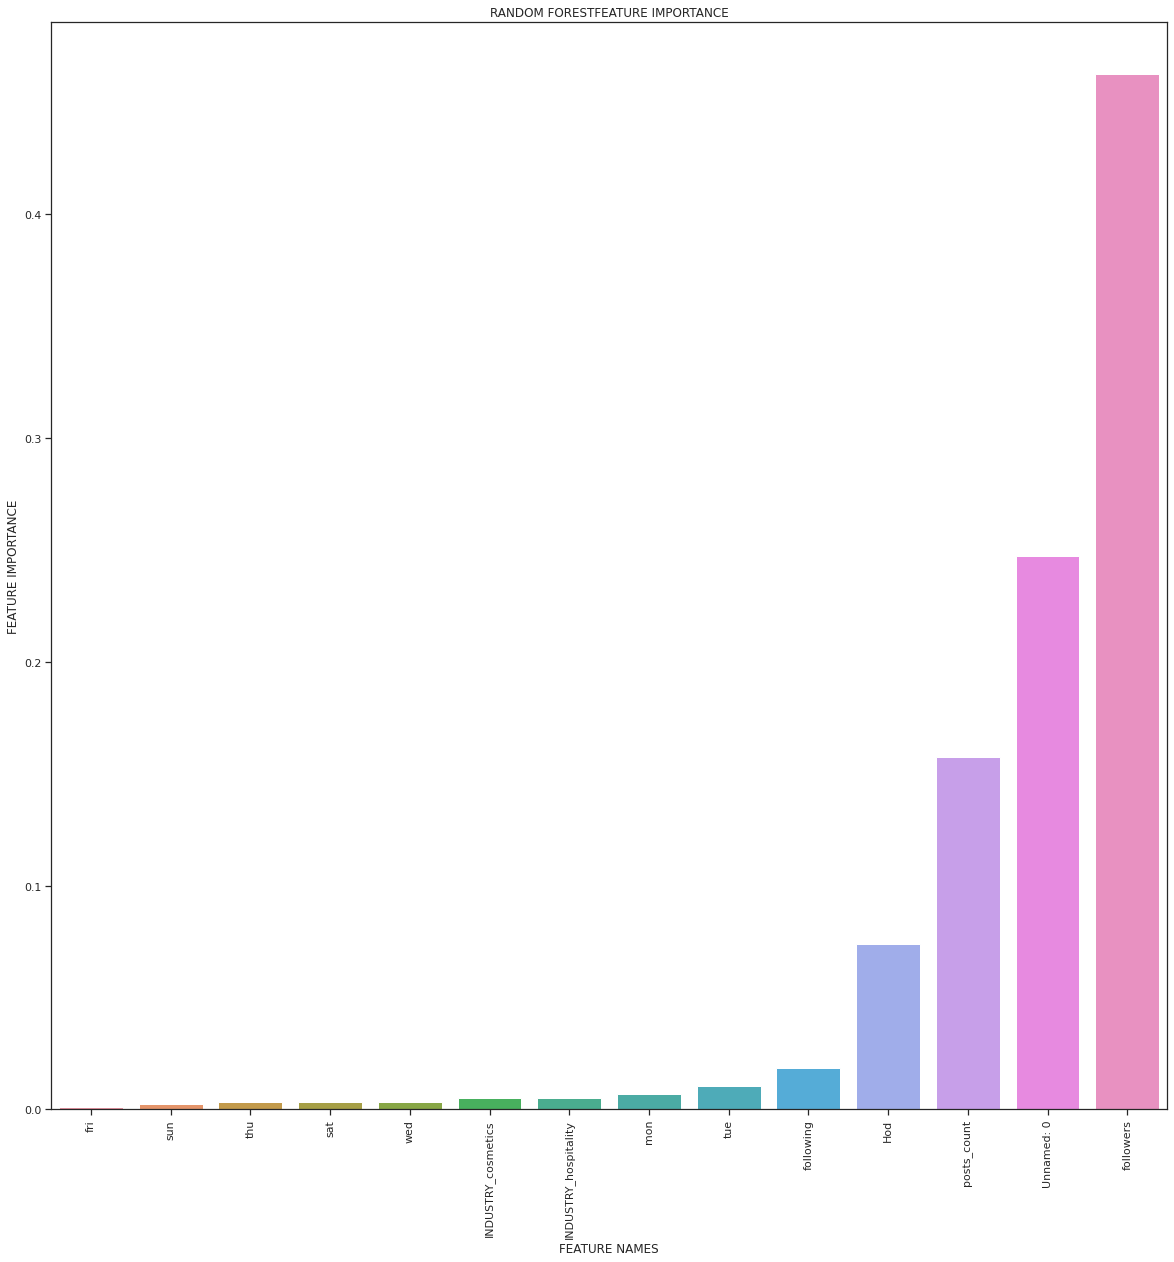

In [57]:
plot_feature_importance(rnd_clf.feature_importances_,X_train.columns,'RANDOM FOREST')

In [58]:
rmse,R2,MAE,MSE,RMSLE,max_error_= metrics(y_test,y_pred_rnd_clf)

dict_info['Model'].append('Random Forest')
dict_info['RMSE'].append(rmse)
dict_info['R2'].append(R2)
dict_info['MAE'].append(MAE)
dict_info['RMSLE'].append(RMSLE)
dict_info['max_error_'].append(max_error_)

RMSE: 0.030394

R2 Score: 0.462481

MAE : 0.008158

MSE : 0.000924

RMSLE : -3.493500

max_error : 0.854531



## MLP Regressor

In [59]:
# hyperparameterTuning_MLP(X_train,y_train)

In [60]:
from sklearn.neural_network import MLPRegressor
mlp_GS = MLPRegressor(activation='relu',alpha=0.001,hidden_layer_sizes=(50, 50, 50),learning_rate='constant',solver='adam',random_state=random_state)
mlp_GS.fit(X_train, y_train)
y_pred_mlp = mlp_GS.predict(X_test)

In [61]:
rmse,R2,MAE,MSE,RMSLE,max_error_= metrics(y_test,y_pred_mlp)

dict_info['Model'].append('MLP')
dict_info['RMSE'].append(rmse)
dict_info['R2'].append(R2)
dict_info['MAE'].append(MAE)
dict_info['RMSLE'].append(RMSLE)
dict_info['max_error_'].append(max_error_)

RMSE: 0.033584

R2 Score: 0.343736

MAE : 0.014210

MSE : 0.001128

RMSLE : -3.393700

max_error : 0.601291



## SVR

In [62]:
svr= LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,tol=0.0001, verbose=0,random_state=random_state)
svr.fit(X_train, y_train)
y_pred_SVR = svr.predict(X_test)

In [63]:
rmse,R2,MAE,MSE,RMSLE,max_error_= metrics(y_test,y_pred_SVR)

dict_info['Model'].append('SVR')
dict_info['RMSE'].append(rmse)
dict_info['R2'].append(R2)
dict_info['MAE'].append(MAE)
dict_info['RMSLE'].append(RMSLE)
dict_info['max_error_'].append(max_error_)

RMSE: 0.043741

R2 Score: -0.113218

MAE : 0.013949

MSE : 0.001913

RMSLE : -3.129477

max_error : 0.920044



In [64]:
dfData = pd.DataFrame(dict_info)
dfData

,Model,RMSE,R2,MAE,RMSLE,max_error_
0,XGboost,0.029022,0.509933,0.008538,-3.539710,0.700299
1,Random Forest,0.030394,0.462481,0.008158,-3.493500,0.854531
2,MLP,0.033584,0.343736,0.014210,-3.393700,0.601291
3,SVR,0.043741,-0.113218,0.013949,-3.129477,0.920044
